In [1]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"
import torch
import matplotlib.pyplot as plt
import time
import math
from torch import nn, optim
from torchvision.datasets import MNIST
from torchvision.transforms import ToPILImage
from torchvision.utils import save_image
import numpy as np

In [2]:
class AutoEncoder(nn.Module):
    def __init__(self):
        super(AutoEncoder, self).__init__()
        # 编码
        self.encoder = nn.Sequential(
            # 输入通道 1，输出通道 32，卷积核 3x3，卷积步长 1
            nn.Conv2d(1, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU()
        )
        # 解码
        self.decoder = nn.Sequential(

            nn.Conv2d(128, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Upsample(scale_factor=2, mode="nearest"),

            nn.Conv2d(64, 1, kernel_size=3, stride=1, padding=1),
            nn.ReLU()
        ) 

    def forward(self, x):
        x = self.encoder(x)
        return self.decoder(x)

In [3]:
class Trainer:
    def __init__(self, batch_size, epochs):
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        print("device: {}".format(self.device))
        self.net = AutoEncoder().to(self.device)
        self.loss_fn = nn.MSELoss()
        self.opt = torch.optim.Adam(self.net.parameters())
        self.BATCH_SIZE = batch_size
        self.EPOCHS = epochs
        
    def get_train_data(self):
        train_set = MNIST(root="./data", train=True)
        origin_x = train_set.data.float()
        
        # 加噪声 
        train_x = torch.clamp(origin_x + torch.randn(60000, 28, 28) * 100, 0, 255) / 255.
        train_y = origin_x / 255.

        return train_x.unsqueeze(1), train_y.unsqueeze(1)

    def get_test_data(self):
        test_set = MNIST(root="./data", train=False)
        origin_x = test_set.data.float()
        test_x = torch.clamp(origin_x + torch.randn(10000, 28, 28) * 100, 0, 255) / 255.
        test_y = origin_x / 255.
        return test_x.unsqueeze(1), test_y.unsqueeze(1)

    def train(self):
        train_x, train_y = self.get_train_data()
        train_x = train_x.to(self.device)
        train_y = train_y.to(self.device)

        # 打乱数据
        index = torch.randperm(train_x.shape[0])
        train_x = train_x[index]
        train_y = train_y[index]

        sample_count = train_x.shape[0]
        batch_count = int(math.ceil(train_x.shape[0] / self.BATCH_SIZE))
        #batch_count /= 2
        print("samples: {}, batches : {}, epochs: {}".format(sample_count, batch_count, self.EPOCHS))
        losses = []
        count = 0
        batchnum = 0
        tic = time.time()
        for i in range(self.EPOCHS):
            epoch_tic = time.time()
            batchnum = 0
            for j in range(0, train_x.shape[0], self.BATCH_SIZE):   
                
                    batchnum += 1
                 #if batchnum <= batch_count:
                    print("batchnum: {} / batch_count: {}".format(batchnum,batch_count))                  
                    x = train_x[j: j+self.BATCH_SIZE]
                    y = train_y[j: j+self.BATCH_SIZE]
                   
                    out = self.net(x)
                    loss = self.loss_fn(out, y)
                    lossval = loss.item()
                    if j%10 == 0:
                        losses.append(lossval)
                        if j%100 == 0:
                        #if j%1 == 0:
                            print("epoch: {} / {}, batch: {} / {}, loss: {}".format(
                                i+1,
                                self.EPOCHS,
                                int(j/self.BATCH_SIZE)+1,
                                batch_count,
                                loss.float()
                            ))                        
                    self.opt.zero_grad()
                    loss.backward()
                    self.opt.step()
                         
            epoch_toc = time.time()
            
            
            plt.clf()          
            fig = plt.gcf()           
            plt.title("loss")         
            plt.plot(losses)
           
            count += 1
            fig.savefig("./imgs/loss/loss_{}.jpg".format(count))
            plt.show()
            print("epoch {} time cost: {}s".format(i+1, epoch_toc - epoch_tic))
            print("*"*20)
        toc = time.time()
        print("train time cost: {}s".format(toc - tic))
        torch.save(self.net, "./models/removenoise.pth")

    def predictModel(self):
        net = torch.load("./models/removenoise.pth")
        test_x, test_y = self.get_test_data()
        test_x = test_x.to(self.device)
        
        
        toPIL = ToPILImage("L")
        fig_count = 0
        for i in range(0, test_x.shape[0], self.BATCH_SIZE):
            x = test_x[i:i + self.BATCH_SIZE]
            y = test_y[i:i + self.BATCH_SIZE]
            
            tic = time.time()
            out = net(x)
            out = torch.sigmoid(out)
            toc = time.time()
            print("batch predict time cost: {}s".format(toc - tic))
            # 每个 batch 输出一次图像 
            for j in range(0, 1):
                plt.clf()
                fig = plt.gcf()
                plt.subplot(1, 3, 1)
                plt.title("Origin Image")
                plt.axis("off")
                plt.imshow(toPIL(y[j]))
                #tensor 转成array形式
                origin_img = np.array(toPIL(y[j]))

                plt.subplot(1, 3, 2)
                plt.title("Noise Image")
                plt.axis("off")
                plt.imshow(toPIL(x[j].cpu()))

                plt.subplot(1, 3, 3)
                plt.title("Output Image")
                plt.axis("off")
                plt.imshow(toPIL(out[j].cpu()))
                out_img = np.array(toPIL(out[j].cpu()))
                print("psnr= ", psnr(origin_img, out_img))

                fig.savefig("./imgs/denoised/denoised_{}.jpg".format(fig_count))
                fig_count += 1
                plt.pause(0.1)
                
                #计算psnr
                

In [4]:

def psnr(im1, im2):
    return 10*np.log10(255*255/np.mean(np.square(im1 - im2)))

In [5]:
def demo(batch_size=512, epochs=50, train=True):
    t = Trainer(batch_size, epochs)
    if train:
        t.train()
    t.predictModel()

device: cuda
samples: 60000, batches : 118, epochs: 3
batchnum: 1 / batch_count: 118
epoch: 1 / 3, batch: 1 / 118, loss: 0.1146736741065979
batchnum: 2 / batch_count: 118
batchnum: 3 / batch_count: 118
batchnum: 4 / batch_count: 118
batchnum: 5 / batch_count: 118
batchnum: 6 / batch_count: 118
batchnum: 7 / batch_count: 118
batchnum: 8 / batch_count: 118
batchnum: 9 / batch_count: 118
batchnum: 10 / batch_count: 118
batchnum: 11 / batch_count: 118
batchnum: 12 / batch_count: 118
batchnum: 13 / batch_count: 118
batchnum: 14 / batch_count: 118
batchnum: 15 / batch_count: 118
batchnum: 16 / batch_count: 118
batchnum: 17 / batch_count: 118
batchnum: 18 / batch_count: 118
batchnum: 19 / batch_count: 118
batchnum: 20 / batch_count: 118
batchnum: 21 / batch_count: 118
batchnum: 22 / batch_count: 118
batchnum: 23 / batch_count: 118
batchnum: 24 / batch_count: 118
batchnum: 25 / batch_count: 118
batchnum: 26 / batch_count: 118
epoch: 1 / 3, batch: 26 / 118, loss: 0.016163697466254234
batchnum: 

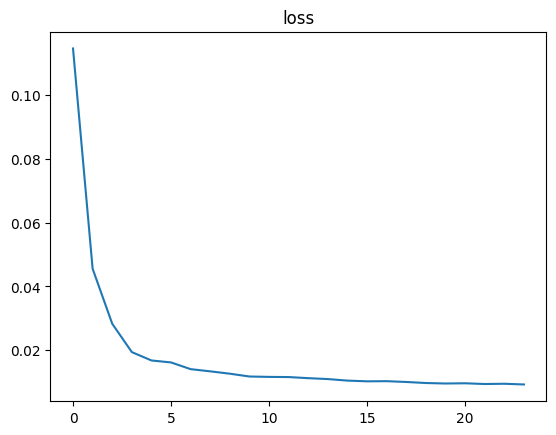

epoch 1 time cost: 8.862336874008179s
********************
batchnum: 1 / batch_count: 118
epoch: 2 / 3, batch: 1 / 118, loss: 0.009226178750395775
batchnum: 2 / batch_count: 118
batchnum: 3 / batch_count: 118
batchnum: 4 / batch_count: 118
batchnum: 5 / batch_count: 118
batchnum: 6 / batch_count: 118
batchnum: 7 / batch_count: 118
batchnum: 8 / batch_count: 118
batchnum: 9 / batch_count: 118
batchnum: 10 / batch_count: 118
batchnum: 11 / batch_count: 118
batchnum: 12 / batch_count: 118
batchnum: 13 / batch_count: 118
batchnum: 14 / batch_count: 118
batchnum: 15 / batch_count: 118
batchnum: 16 / batch_count: 118
batchnum: 17 / batch_count: 118
batchnum: 18 / batch_count: 118
batchnum: 19 / batch_count: 118
batchnum: 20 / batch_count: 118
batchnum: 21 / batch_count: 118
batchnum: 22 / batch_count: 118
batchnum: 23 / batch_count: 118
batchnum: 24 / batch_count: 118
batchnum: 25 / batch_count: 118
batchnum: 26 / batch_count: 118
epoch: 2 / 3, batch: 26 / 118, loss: 0.009176039136946201
bat

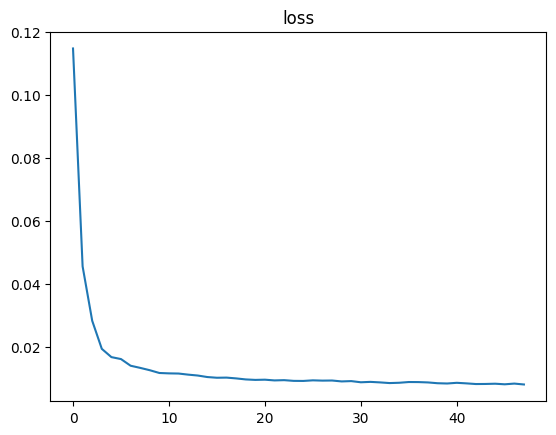

epoch 2 time cost: 6.2080488204956055s
********************
batchnum: 1 / batch_count: 118
epoch: 3 / 3, batch: 1 / 118, loss: 0.00817857775837183
batchnum: 2 / batch_count: 118
batchnum: 3 / batch_count: 118
batchnum: 4 / batch_count: 118
batchnum: 5 / batch_count: 118
batchnum: 6 / batch_count: 118
batchnum: 7 / batch_count: 118
batchnum: 8 / batch_count: 118
batchnum: 9 / batch_count: 118
batchnum: 10 / batch_count: 118
batchnum: 11 / batch_count: 118
batchnum: 12 / batch_count: 118
batchnum: 13 / batch_count: 118
batchnum: 14 / batch_count: 118
batchnum: 15 / batch_count: 118
batchnum: 16 / batch_count: 118
batchnum: 17 / batch_count: 118
batchnum: 18 / batch_count: 118
batchnum: 19 / batch_count: 118
batchnum: 20 / batch_count: 118
batchnum: 21 / batch_count: 118
batchnum: 22 / batch_count: 118
batchnum: 23 / batch_count: 118
batchnum: 24 / batch_count: 118
batchnum: 25 / batch_count: 118
batchnum: 26 / batch_count: 118
epoch: 3 / 3, batch: 26 / 118, loss: 0.00829737726598978
batc

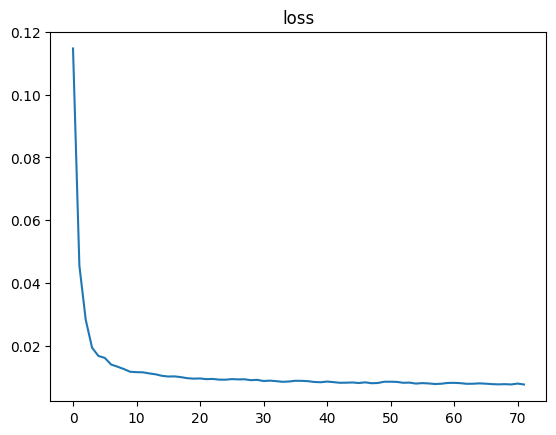

epoch 3 time cost: 6.103500127792358s
********************
train time cost: 21.493099689483643s
batch predict time cost: 0.0040035247802734375s
psnr=  35.795144800677235


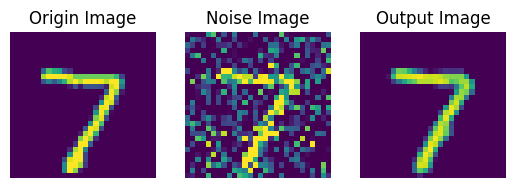

batch predict time cost: 0.0010008811950683594s
psnr=  35.246680054280816


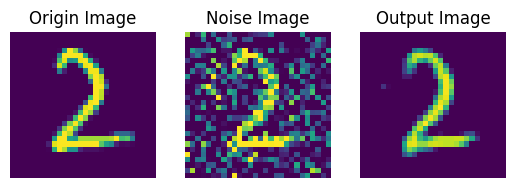

batch predict time cost: 0.0010013580322265625s
psnr=  35.35260726902782


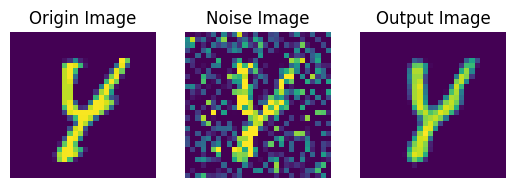

batch predict time cost: 0.0010006427764892578s
psnr=  34.204462077648


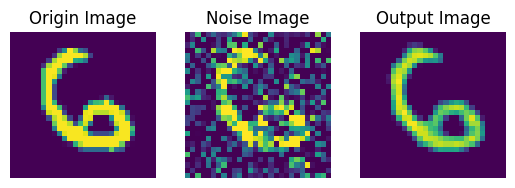

batch predict time cost: 0.0010018348693847656s
psnr=  33.715375122325305


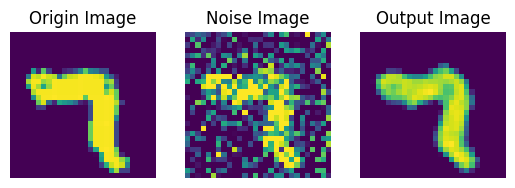

batch predict time cost: 0.001001119613647461s
psnr=  35.06627978769177


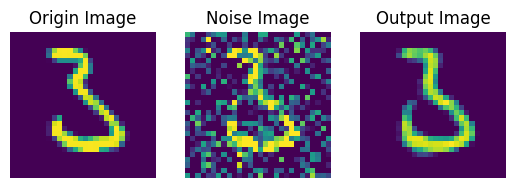

batch predict time cost: 0.0010008811950683594s
psnr=  34.36228844604261


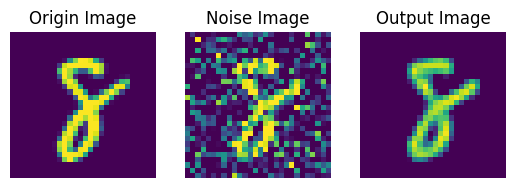

batch predict time cost: 0.001001119613647461s
psnr=  33.90085403345537


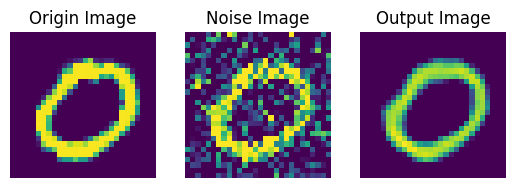

batch predict time cost: 0.001001119613647461s
psnr=  35.09069305828871


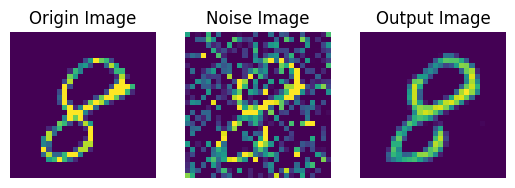

batch predict time cost: 0.001001119613647461s
psnr=  34.06040829111225


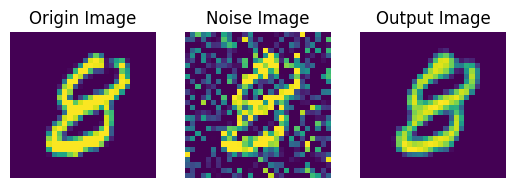

batch predict time cost: 0.0009267330169677734s
psnr=  34.22244345027258


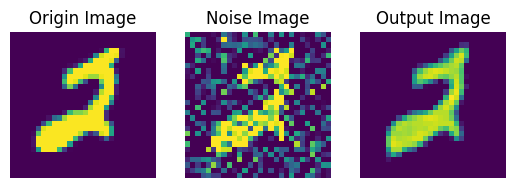

batch predict time cost: 0.001001119613647461s
psnr=  34.66622598268156


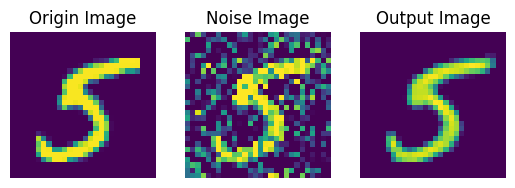

batch predict time cost: 0.001001596450805664s
psnr=  34.21704121698261


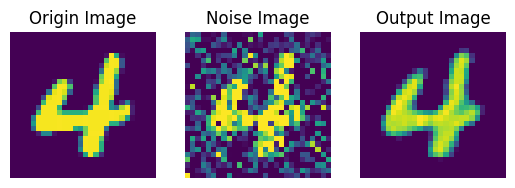

batch predict time cost: 0.0s
psnr=  35.04009931891871


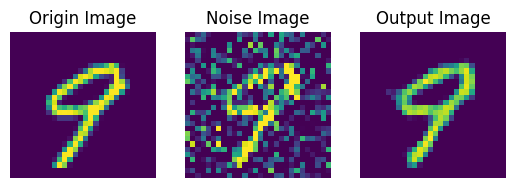

batch predict time cost: 0.0010006427764892578s
psnr=  33.82846475849794


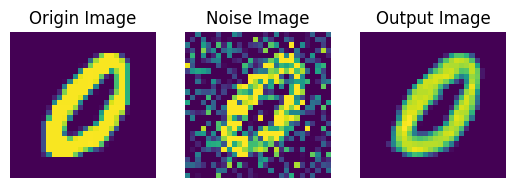

batch predict time cost: 0.0010008811950683594s
psnr=  35.62106764498202


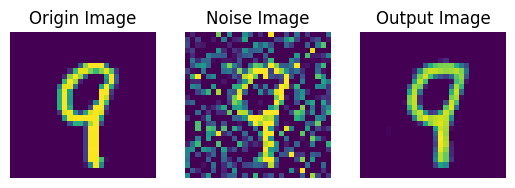

batch predict time cost: 0.001001119613647461s
psnr=  34.37206880848167


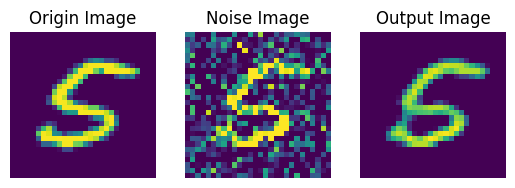

batch predict time cost: 0.001001596450805664s
psnr=  34.30406434184118


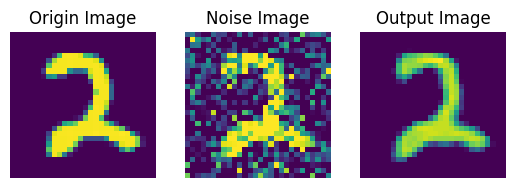

batch predict time cost: 0.0010018348693847656s
psnr=  34.216366410069064


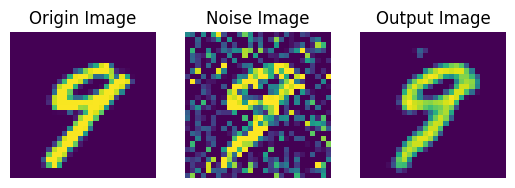

batch predict time cost: 0.002002239227294922s
psnr=  34.923672454580476


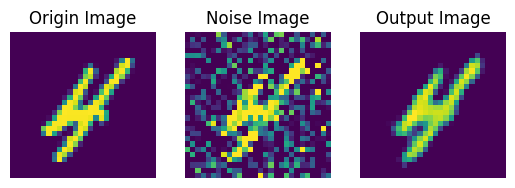

In [6]:
if __name__ == '__main__':
    batch_size = 512
    epochs = 3
    # train 决定是否重新训练
    demo(batch_size, epochs, train=True)